In [1]:
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from custom_lstm import CustomLSTM as LSTMRaw
from plstm_cell import PLSTM
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

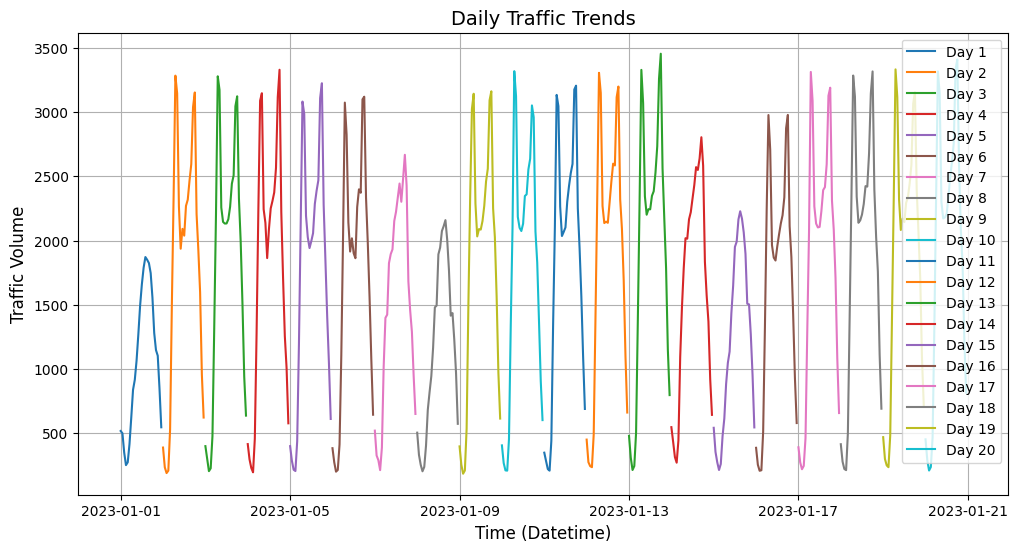

In [ ]:

df = pd.read_csv("df.csv")
df['datetime'] = pd.to_datetime(df['datetime'])
df['date'] = df['datetime'].dt.date
df['hour'] = df['datetime'].dt.hour


daily_data = [group for _, group in df.groupby('date')]


plt.figure(figsize=(12, 6))


num_samples = min(20, len(daily_data)) 
for i, day_data in enumerate(daily_data[:num_samples]):
    plt.plot(day_data['datetime'], day_data['traffic'], label=f"Day {i+1}")


plt.title("Daily Traffic Trends", fontsize=14)
plt.xlabel("Time (Datetime)", fontsize=12)
plt.ylabel("Traffic Volume", fontsize=12)
plt.legend(loc='upper right')
plt.grid()
plt.show()


In [3]:
df.head()

,datetime,traffic,date,hour
0,2023-01-01 00:00:00,515,2023-01-01,0
1,2023-01-01 01:00:00,497,2023-01-01,1
2,2023-01-01 02:00:00,346,2023-01-01,2
3,2023-01-01 03:00:00,249,2023-01-01,3
4,2023-01-01 04:00:00,271,2023-01-01,4


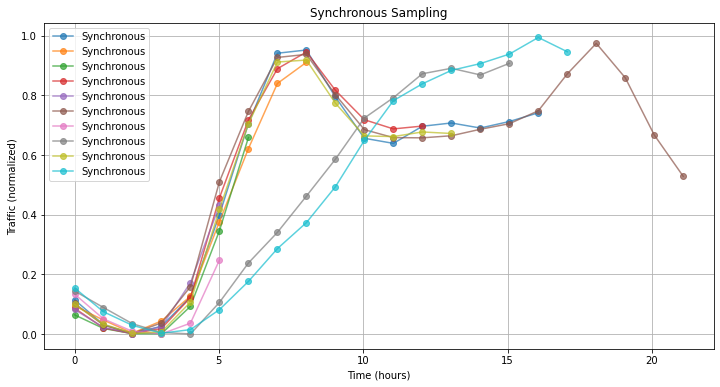

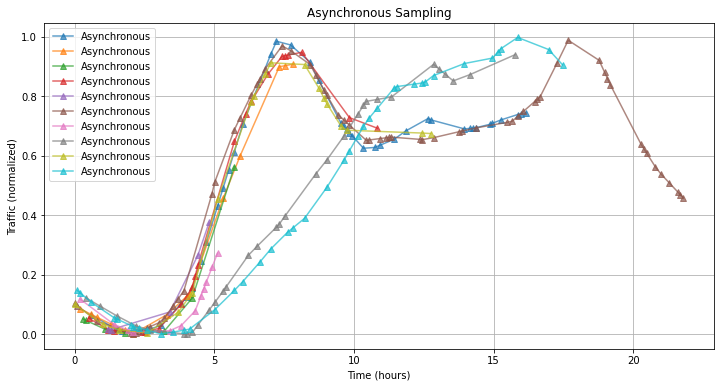

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d


seed = 42 
np.random.seed(seed)


selected_days = np.random.choice(len(daily_data), 365, replace=False)
selected_data = [daily_data[i] for i in selected_days]



augmented_data = []
time_points = np.linspace(0, 24, 240) 

for day in selected_data:

    traffic = day['traffic'].values
    traffic_normalized = (traffic - traffic.min()) / (traffic.max() - traffic.min())
    

    interp_func = interp1d(
        np.linspace(0, 24, len(traffic_normalized)), 
        traffic_normalized, 
        kind='linear'
    )
    traffic_resampled = interp_func(time_points)


    duration = np.random.uniform(5, 24)
    

    valid_idx = time_points <= duration
    augmented_data.append((time_points[valid_idx], traffic_resampled[valid_idx]))


synchronous_samples = []
asynchronous_samples = []


for time_points, traffic_values in augmented_data:

    sync_idx = np.arange(0, len(time_points), step=10) 
    sync_sample_t = time_points[sync_idx]
    sync_sample_p = traffic_values[sync_idx]
    synchronous_samples.append((sync_sample_t, sync_sample_p))


    async_idx = np.sort(np.random.choice(len(time_points), size=np.random.randint(5, len(time_points)//3), replace=False))
    async_sample_t = time_points[async_idx]
    async_sample_p = traffic_values[async_idx]
    asynchronous_samples.append((async_sample_t, async_sample_p))


plt.figure(figsize=(12, 6))
for t, p in synchronous_samples[:10]: 
    plt.plot(t, p, 'o-', label='Synchronous', alpha=0.7)
plt.title("Synchronous Sampling")
plt.xlabel("Time (hours)")
plt.ylabel("Traffic (normalized)")
plt.legend()
plt.grid()
plt.show()


plt.figure(figsize=(12, 6))
for t, p in asynchronous_samples[:10]:
    plt.plot(t, p, '^-', label='Asynchronous', alpha=0.7)
plt.title("Asynchronous Sampling")
plt.xlabel("Time (hours)")
plt.ylabel("Traffic (normalized)")
plt.legend()
plt.grid()
plt.show()


Training LSTM with Synchronous Sampling
[Epoch 1/100] Training Loss: 0.7353, Test Accuracy: 39.18%
[Epoch 2/100] Training Loss: 0.7108, Test Accuracy: 39.18%
[Epoch 3/100] Training Loss: 0.6879, Test Accuracy: 76.44%
[Epoch 4/100] Training Loss: 0.6576, Test Accuracy: 61.37%
[Epoch 5/100] Training Loss: 0.5943, Test Accuracy: 70.14%
[Epoch 6/100] Training Loss: 0.4483, Test Accuracy: 94.79%
[Epoch 7/100] Training Loss: 0.3197, Test Accuracy: 89.59%
[Epoch 8/100] Training Loss: 0.2737, Test Accuracy: 95.62%
[Epoch 9/100] Training Loss: 0.2422, Test Accuracy: 96.99%
[Epoch 10/100] Training Loss: 0.2184, Test Accuracy: 97.81%
[Epoch 11/100] Training Loss: 0.1838, Test Accuracy: 96.71%
[Epoch 12/100] Training Loss: 0.1615, Test Accuracy: 97.26%
[Epoch 13/100] Training Loss: 0.1388, Test Accuracy: 96.16%
[Epoch 14/100] Training Loss: 0.1284, Test Accuracy: 98.08%
[Epoch 15/100] Training Loss: 0.1077, Test Accuracy: 95.62%
[Epoch 16/100] Training Loss: 0.1024, Test Accuracy: 98.08%
[Epoch 17

c:\Users\PC\OneDrive - UNIST (1)\final\plstm_cell.py:38: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  ..\aten\src\ATen\native\BinaryOps.cpp:601.)
  return grad_output * 1, grad_output * torch.neg(torch.floor_divide(x, y))


[Epoch 1/100] Training Loss: 0.7069, Test Accuracy: 39.18%
[Epoch 2/100] Training Loss: 0.7004, Test Accuracy: 39.18%
[Epoch 3/100] Training Loss: 0.6931, Test Accuracy: 39.18%
[Epoch 4/100] Training Loss: 0.6857, Test Accuracy: 43.01%
[Epoch 5/100] Training Loss: 0.6754, Test Accuracy: 75.62%
[Epoch 6/100] Training Loss: 0.6627, Test Accuracy: 92.60%
[Epoch 7/100] Training Loss: 0.6466, Test Accuracy: 92.60%
[Epoch 8/100] Training Loss: 0.6268, Test Accuracy: 90.68%
[Epoch 9/100] Training Loss: 0.5963, Test Accuracy: 90.68%
[Epoch 10/100] Training Loss: 0.5561, Test Accuracy: 91.78%
[Epoch 11/100] Training Loss: 0.5049, Test Accuracy: 90.96%
[Epoch 12/100] Training Loss: 0.4574, Test Accuracy: 92.60%
[Epoch 13/100] Training Loss: 0.4026, Test Accuracy: 92.60%
[Epoch 14/100] Training Loss: 0.3495, Test Accuracy: 92.60%
[Epoch 15/100] Training Loss: 0.3076, Test Accuracy: 92.60%
[Epoch 16/100] Training Loss: 0.2776, Test Accuracy: 92.60%
[Epoch 17/100] Training Loss: 0.2526, Test Accura

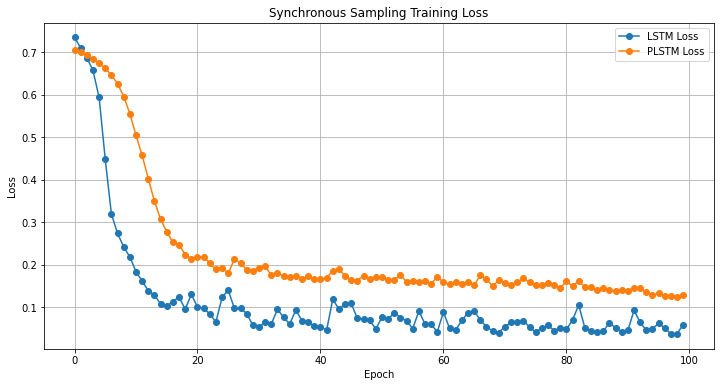

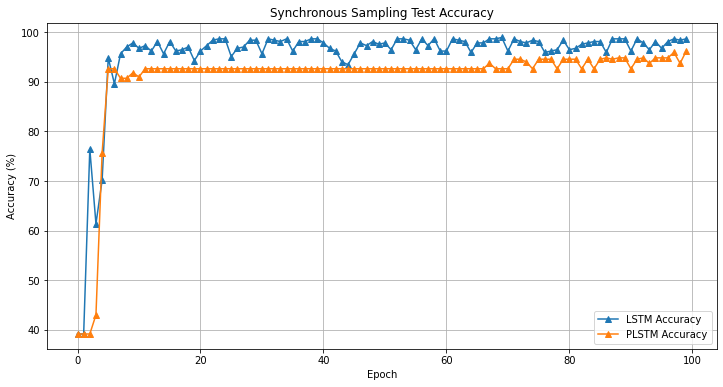


Training LSTM with Asynchronous Sampling
[Epoch 1/100] Training Loss: 0.6819, Test Accuracy: 58.36%
[Epoch 2/100] Training Loss: 0.6814, Test Accuracy: 58.36%
[Epoch 3/100] Training Loss: 0.6802, Test Accuracy: 58.36%
[Epoch 4/100] Training Loss: 0.6782, Test Accuracy: 58.36%
[Epoch 5/100] Training Loss: 0.6805, Test Accuracy: 58.36%
[Epoch 6/100] Training Loss: 0.6777, Test Accuracy: 58.36%
[Epoch 7/100] Training Loss: 0.6808, Test Accuracy: 58.36%
[Epoch 8/100] Training Loss: 0.6756, Test Accuracy: 58.36%
[Epoch 9/100] Training Loss: 0.6733, Test Accuracy: 58.36%
[Epoch 10/100] Training Loss: 0.6742, Test Accuracy: 58.36%
[Epoch 11/100] Training Loss: 0.6690, Test Accuracy: 60.00%
[Epoch 12/100] Training Loss: 0.6543, Test Accuracy: 64.38%
[Epoch 13/100] Training Loss: 0.6190, Test Accuracy: 71.78%
[Epoch 14/100] Training Loss: 0.5481, Test Accuracy: 81.10%
[Epoch 15/100] Training Loss: 0.5333, Test Accuracy: 67.12%
[Epoch 16/100] Training Loss: 0.5056, Test Accuracy: 85.48%
[Epoch 

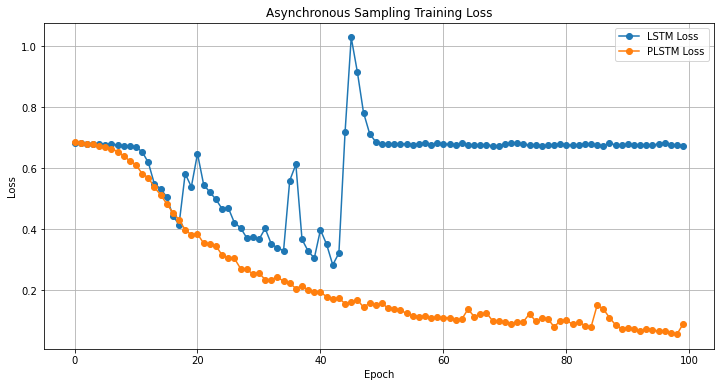

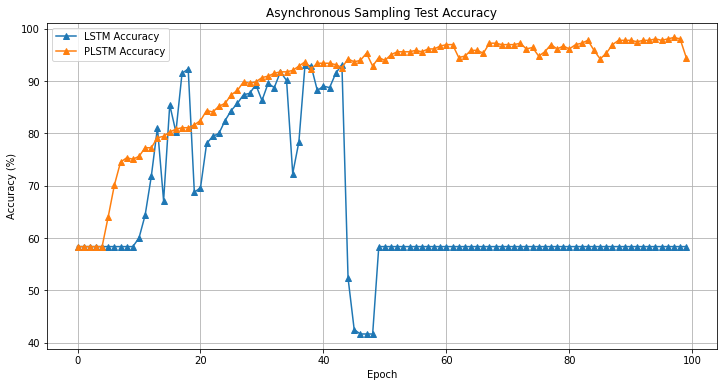

Calculating Final MSE for Synchronous Sampling
Final MSE for LSTM (Synchronous Sampling): 0.0137
Final MSE for PLSTM (Synchronous Sampling): 0.0384

Calculating Final MSE for Asynchronous Sampling
Final MSE for LSTM (Asynchronous Sampling): 0.4164
Final MSE for PLSTM (Asynchronous Sampling): 0.0548


In [ ]:

class TrafficDataset(Dataset):
    def __init__(self, samples, threshold=0.5):
        self.samples = samples
        self.threshold = threshold

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        time_points, traffic_values = self.samples[idx]
        inputs = torch.tensor(traffic_values, dtype=torch.float32).unsqueeze(-1)
        times = torch.tensor(time_points, dtype=torch.float32)
        label = torch.tensor(1 if traffic_values.mean() > self.threshold else 0, dtype=torch.long)
        return inputs, times, label


def collate_fn(batch):
    inputs, times, labels = zip(*batch)
    padded_inputs = pad_sequence(inputs, batch_first=True, padding_value=0)
    padded_times = pad_sequence(times, batch_first=True, padding_value=0)
    labels = torch.stack(labels)
    return padded_inputs, padded_times, labels


class TrafficNet(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=20, use_lstm=True):
        super(TrafficNet, self).__init__()
        self.use_lstm = use_lstm
        if use_lstm:
            self.rnn = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        else:
            self.rnn = PLSTM(input_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, 2)

    def forward(self, inputs, times):
        if self.use_lstm:
            rnn_out, _ = self.rnn(inputs)
        else:
            rnn_out, _ = self.rnn(inputs, times)
        output = self.fc(rnn_out[:, -1, :])
        return F.log_softmax(output, dim=-1)


def train(model, device, train_loader, optimizer):
    model.train()
    epoch_loss = 0
    for inputs, times, labels in train_loader:
        inputs, times, labels = inputs.to(device), times.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs, times)
        loss = F.nll_loss(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss / len(train_loader)

def test(model, device, test_loader):
    model.eval()
    correct = 0
    with torch.no_grad():
        for inputs, times, labels in test_loader:
            inputs, times, labels = inputs.to(device), times.to(device), labels.to(device)
            outputs = model(inputs, times)
            pred = outputs.argmax(dim=1)
            correct += pred.eq(labels).sum().item()
    return 100. * correct / len(test_loader.dataset)


def plot_results(losses_lstm, losses_plstm, acc_lstm, acc_plstm, title):
    plt.figure(figsize=(12, 6))
    plt.plot(losses_lstm, label="LSTM Loss", marker="o")
    plt.plot(losses_plstm, label="PLSTM Loss", marker="o")
    plt.title(f"{title} Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid()
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.plot(acc_lstm, label="LSTM Accuracy", marker="^")
    plt.plot(acc_plstm, label="PLSTM Accuracy", marker="^")
    plt.title(f"{title} Test Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.legend()
    plt.grid()
    plt.show()


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
epochs = 100
batch_size = 32


train_dataset_sync = TrafficDataset(synchronous_samples)
test_dataset_sync = TrafficDataset(synchronous_samples)
train_loader_sync = DataLoader(train_dataset_sync, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
test_loader_sync = DataLoader(test_dataset_sync, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)


train_dataset_async = TrafficDataset(asynchronous_samples)
test_dataset_async = TrafficDataset(asynchronous_samples)
train_loader_async = DataLoader(train_dataset_async, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
test_loader_async = DataLoader(test_dataset_async, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)


lstm_sync_losses, lstm_sync_acc = [], []
plstm_sync_losses, plstm_sync_acc = [], []

# LSTM
print("Training LSTM with Synchronous Sampling")
model_lstm_sync = TrafficNet(use_lstm=True).to(device)
optimizer_lstm_sync = torch.optim.Adam(model_lstm_sync.parameters(), lr=0.001)
for epoch in range(epochs):
    loss = train(model_lstm_sync, device, train_loader_sync, optimizer_lstm_sync)
    accuracy = test(model_lstm_sync, device, test_loader_sync)
    lstm_sync_losses.append(loss)
    lstm_sync_acc.append(accuracy)
    print(f"[Epoch {epoch+1}/{epochs}] Training Loss: {loss:.4f}, Test Accuracy: {accuracy:.2f}%")

# PLSTM
print("\nTraining PLSTM with Synchronous Sampling")
model_plstm_sync = TrafficNet(use_lstm=False).to(device)
optimizer_plstm_sync = torch.optim.Adam(model_plstm_sync.parameters(), lr=0.001)
for epoch in range(epochs):
    loss = train(model_plstm_sync, device, train_loader_sync, optimizer_plstm_sync)
    accuracy = test(model_plstm_sync, device, test_loader_sync)
    plstm_sync_losses.append(loss)
    plstm_sync_acc.append(accuracy)
    print(f"[Epoch {epoch+1}/{epochs}] Training Loss: {loss:.4f}, Test Accuracy: {accuracy:.2f}%")


plot_results(lstm_sync_losses, plstm_sync_losses, lstm_sync_acc, plstm_sync_acc, "Synchronous Sampling")


lstm_async_losses, lstm_async_acc = [], []
plstm_async_losses, plstm_async_acc = [], []

# LSTM
print("\nTraining LSTM with Asynchronous Sampling")
model_lstm_async = TrafficNet(use_lstm=True).to(device)
optimizer_lstm_async = torch.optim.Adam(model_lstm_async.parameters(), lr=0.001)
for epoch in range(epochs):
    loss = train(model_lstm_async, device, train_loader_async, optimizer_lstm_async)
    accuracy = test(model_lstm_async, device, test_loader_async)
    lstm_async_losses.append(loss)
    lstm_async_acc.append(accuracy)
    print(f"[Epoch {epoch+1}/{epochs}] Training Loss: {loss:.4f}, Test Accuracy: {accuracy:.2f}%")

# PLSTM
print("\nTraining PLSTM with Asynchronous Sampling")
model_plstm_async = TrafficNet(use_lstm=False).to(device)
optimizer_plstm_async = torch.optim.Adam(model_plstm_async.parameters(), lr=0.001)
for epoch in range(epochs):
    loss = train(model_plstm_async, device, train_loader_async, optimizer_plstm_async)
    accuracy = test(model_plstm_async, device, test_loader_async)
    plstm_async_losses.append(loss)
    plstm_async_acc.append(accuracy)
    print(f"[Epoch {epoch+1}/{epochs}] Training Loss: {loss:.4f}, Test Accuracy: {accuracy:.2f}%")



plot_results(lstm_async_losses, plstm_async_losses, lstm_async_acc, plstm_async_acc, "Asynchronous Sampling")


def calculate_mse(model, device, data_loader):
    model.eval()
    mse_loss = 0
    total_samples = 0
    with torch.no_grad():
        for inputs, times, labels in data_loader:
            inputs, times = inputs.to(device), times.to(device)
            outputs = model(inputs, times)
            predictions = outputs.argmax(dim=1).float()
            mse_loss += ((predictions - labels.float().to(device)) ** 2).sum().item()
            total_samples += len(labels)
    return mse_loss / total_samples


print("Calculating Final MSE for Synchronous Sampling")
mse_lstm_sync = calculate_mse(model_lstm_sync, device, test_loader_sync)
mse_plstm_sync = calculate_mse(model_plstm_sync, device, test_loader_sync)
print(f"Final MSE for LSTM (Synchronous Sampling): {mse_lstm_sync:.4f}")
print(f"Final MSE for PLSTM (Synchronous Sampling): {mse_plstm_sync:.4f}")

print("\nCalculating Final MSE for Asynchronous Sampling")
mse_lstm_async = calculate_mse(model_lstm_async, device, test_loader_async)
mse_plstm_async = calculate_mse(model_plstm_async, device, test_loader_async)
print(f"Final MSE for LSTM (Asynchronous Sampling): {mse_lstm_async:.4f}")
print(f"Final MSE for PLSTM (Asynchronous Sampling): {mse_plstm_async:.4f}")

